In [1]:
import sys
sys.path.append('../')

In [2]:
import importlib
from collections import defaultdict
import numpy as np
import pandas as pd
import lib.recommenders as rec
import networkx as nx
import matplotlib.pyplot as plt
import lib.areamanager
import math
import time
from IPython.core.debugger import set_trace
import lib.geocat.objfunc as gcobjfunc
import lib.cat_utils as cat_utils

from lib.constants import experiment_constants
import lib.metrics as metrics
import pickle
%matplotlib inline
import scipy.stats
from lib.metricscontroller import MetricsController

import lib.pgc.pgc as pgc

def string_to_array(string):
    if string == '':
        return list()
    return eval(string)
importlib.reload(pgc)
importlib.reload(lib.metricscontroller)
importlib.reload(lib.constants)
importlib.reload(rec)
importlib.reload(gcobjfunc)
importlib.reload(cat_utils)
importlib.reload(lib.metricscontroller)
N=experiment_constants.N
K=experiment_constants.K
CITY=experiment_constants.CITY
METRICS_K=experiment_constants.METRICS_K

In [3]:
#Train load
data_checkin_train = pickle.load(open("../../data/checkin/train/"+CITY+".pickle","rb"))

#Test load
ground_truth = defaultdict(set)
for checkin in pickle.load(open("../../data/checkin/test/"+CITY+".pickle","rb")):
    ground_truth[checkin['user_id']].add(checkin['poi_id'])
#Pois load
poi_coos = {}
poi_cats = {}
for poi_id,poi in pickle.load(open("../../data/poi/"+CITY+".pickle","rb")).items():
    poi_coos[poi_id] = tuple([poi['latitude'],poi['longitude']])
    poi_cats[poi_id] = poi['categories']
    
#Social relations load
social_relations = defaultdict(list)
for user_id,friends in pickle.load(open("../../data/user/"+CITY+".pickle","rb")).items():
    social_relations[user_id]=friends

user_num = len(social_relations)
poi_num = len(poi_coos)
user_num,poi_num

# Cat Hierarchy load
dict_alias_title,category_tree,dict_alias_depth=cat_utils.cat_structs("../../data/categories.json")
undirected_category_tree=category_tree.to_undirected()

# Training matrix create
training_matrix = np.zeros((user_num, poi_num))
for checkin in data_checkin_train:
    training_matrix[checkin['user_id'],checkin['poi_id']]+=1

# poi neighbors load
poi_neighbors=pickle.load(open("../../data/neighbor/"+CITY+".pickle","rb"))

In [4]:
importlib.reload(pgc)
users_cmean_dist=pgc.cmean_dist_users(training_matrix,poi_coos)

city_cmean_dist=pgc.cmean_dist_pois(poi_coos)

geo_div_prop=pgc.geo_div_propensity(users_cmean_dist,city_cmean_dist)

users_cmean_dist=np.sort(users_cmean_dist)
geo_div_prop=np.sort(geo_div_prop)

Text(0, 0.5, 'centroid mean distance')

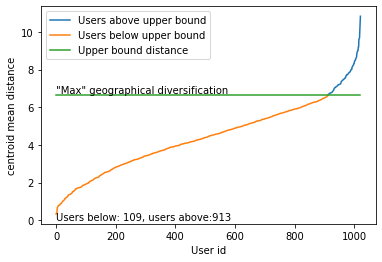

In [5]:
#Mean

uupper=np.ma.masked_where(users_cmean_dist >= city_cmean_dist, users_cmean_dist)
ulower=np.ma.masked_where(users_cmean_dist < city_cmean_dist, users_cmean_dist)
t=np.arange(0,training_matrix.shape[0],1)
plt.plot(t, ulower, t, uupper,t,[city_cmean_dist]*training_matrix.shape[0])

plt.annotate('"Max" geographical diversification', xy=(1, 1), xytext=(1, city_cmean_dist+0.1))
plt.annotate("Users below: "+str(len(ulower[ulower.mask == False]))+", users above:"+str(len(uupper[uupper.mask == False])), xy=(0, 0), xytext=(0,0))
# plt.plot(np.sort(users_cmean_dist))
plt.legend(('Users above upper bound', 'Users below upper bound', 'Upper bound distance'))
plt.xlabel("User id")
plt.ylabel("centroid mean distance")

In [6]:
importlib.reload(pgc)
users_cmean_dist=pgc.cmedian_dist_users(training_matrix,poi_coos)
users_cmean_dist=np.array(users_cmean_dist)
city_cmean_dist=pgc.cmedian_dist_pois(poi_coos)

geo_div_prop=pgc.geo_div_propensity(users_cmean_dist,city_cmean_dist)
user_rank_geo_div_prop=np.argsort(users_cmean_dist)
users_cmean_dist=users_cmean_dist[user_rank_geo_div_prop]
geo_div_prop=geo_div_prop[user_rank_geo_div_prop]

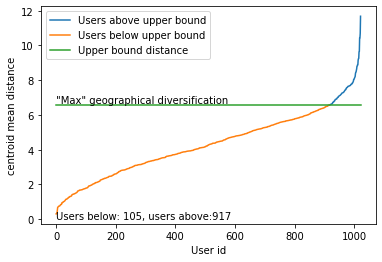

In [7]:
#Median

uupper=np.ma.masked_where(users_cmean_dist >= city_cmean_dist, users_cmean_dist)
ulower=np.ma.masked_where(users_cmean_dist < city_cmean_dist, users_cmean_dist)
t=np.arange(0,training_matrix.shape[0],1)
plt.plot(t, ulower, t, uupper,t,[city_cmean_dist]*training_matrix.shape[0])

plt.annotate('"Max" geographical diversification', xy=(1, 1), xytext=(1, city_cmean_dist+0.1))
plt.annotate("Users below: "+str(len(ulower[ulower.mask == False]))+", users above:"+str(len(uupper[uupper.mask == False])), xy=(0, 0), xytext=(0,0))
# plt.plot(np.sort(users_cmean_dist))
plt.legend(('Users above upper bound', 'Users below upper bound', 'Upper bound distance'))
plt.xlabel("User id")
plt.ylabel("centroid mean distance")
plt.savefig('cmd_madison.png')
plt.show()

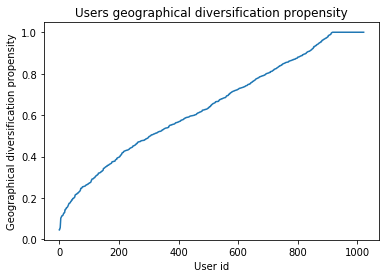

In [8]:
plt.plot(geo_div_prop)
plt.xlabel("User id")
plt.ylabel("Geographical diversification propensity")
plt.title("Users geographical diversification propensity")
plt.savefig('gdp_madison.png')
plt.show()

In [9]:
importlib.reload(pgc)
uid_cat_visits=cat_utils.get_users_cat_visits(training_matrix,poi_cats)
cat_div_prop=np.array(pgc.cat_div_propensity(uid_cat_visits))[user_rank_geo_div_prop]

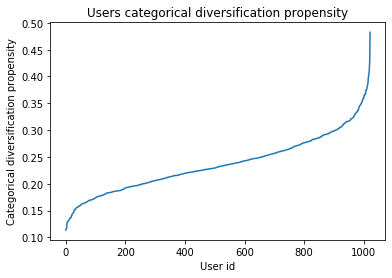

In [10]:
plt.plot(np.sort(cat_div_prop))
plt.xlabel("User id")
plt.ylabel("Categorical diversification propensity")
plt.title("Users categorical diversification propensity")
plt.savefig('cdp_madison.png')
plt.show()

user min
skew=5.544969739470018
kurtosis=36.920457089991416


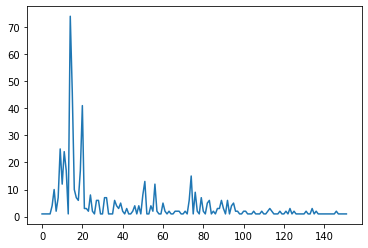

user median
skew=2.8026286661368642
kurtosis=7.268816953798725


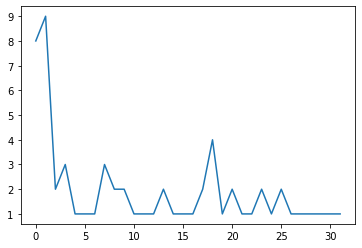

user max
skew=0.3869552767307012
kurtosis=-1.8202518549630817


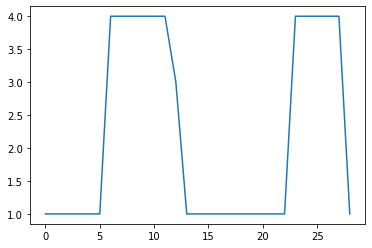

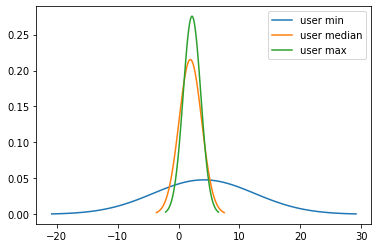

In [11]:

cat_div_prop=np.array(pgc.cat_div_propensity(uid_cat_visits))

uids=dict()
uids['user min']=(np.argmin(cat_div_prop))
uids['user median']=(np.argsort(cat_div_prop)[len(cat_div_prop)//2])
uids['user max']=(np.argmax(cat_div_prop))
for user_type in uids:
    uid=uids[user_type]
    print(user_type)
    plt.plot(uid_cat_visits[uid])
    print(f"""skew={scipy.stats.skew(uid_cat_visits[uid])}
kurtosis={scipy.stats.kurtosis(uid_cat_visits[uid])}""")
    plt.show()
    
for user_type in uids:
    uid=uids[user_type]
    mu = np.mean(uid_cat_visits[uid])

    sigma = np.std(uid_cat_visits[uid])
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, scipy.stats.norm.pdf(x, mu, sigma))
plt.legend(list(uids.keys()))
plt.show()


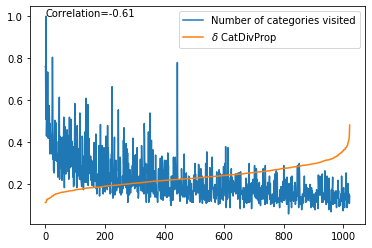

In [13]:
argres=np.argsort(cat_div_prop)
uid_cats=np.array(list(map(len,uid_cat_visits)))[argres]


plt.plot(uid_cats/np.max(uid_cats))
plt.plot(cat_div_prop[argres])
plt.annotate('Correlation='+f"{np.corrcoef(cat_div_prop[argres],uid_cats)[0,1]:.2f}", xy=(0, 1))
plt.legend(["Number of categories visited","$\delta$ CatDivProp"])
plt.savefig('cdp_nc_madison.png')
plt.show()

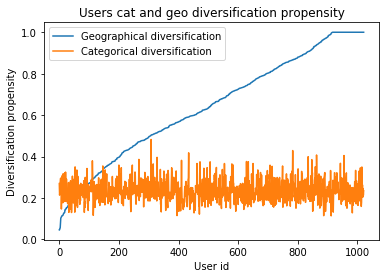

In [14]:
plt.plot(t,geo_div_prop,t,cat_div_prop)
plt.legend(("Geographical diversification","Categorical diversification"))
plt.xlabel("User id")
plt.ylabel("Diversification propensity")
plt.title("Users cat and geo diversification propensity")
plt.savefig('gcdp_madison.png')
plt.show()

$div_{geo-cat}(i,R)=\beta\cdot div_{geo}(i,R)+(1-\beta)\cdot div_{cat}(i,R)$

$div_{geo-cat}(i,R)=\frac{\gamma}{\gamma+\delta}\cdot div_{geo}(i,R)+(1-\frac{\gamma}{\gamma+\delta})\cdot div_{cat}(i,R)$

$div_{geo-cat}(i,R)=\frac{\gamma}{\gamma+\delta}\cdot div_{geo}(i,R)+\frac{\delta}{\gamma+\delta}\cdot div_{cat}(i,R)$

$\gamma+\delta = 0 \implies \gamma=0 \land \delta=0$

$Visit: U\times L \implies \{0,1\}$

$u\in U$

$Lat = Latitude$

$Lon = Longitude$

$CLat_u=\frac{\sum_{i=0}^{|L|-1} Visit(u,L_i)\cdot Lat(L_i)}
{\sum_{i=0}^{|L|-1}Visit(u,L_i)}$

$CLon_u=\frac{\sum_{i=0}^{|L|-1} Visit(u,L_i)\cdot Lon(L_i)}
{\sum_{i=0}^{|L|-1}Visit(u,L_i)}$

$Centroid=C_u=(CLat_u,CLon_u)$

$Dist: (\mathbb{R},\mathbb{R}) \implies \mathbb{R} = $ Geographical distance

$D \in \mathbb{R}$

$D_u=\frac{\sum_{i=0}^{|L|-1} Visit(u,L_i)\cdot Dist(C_u,(Lat(L_i),Lon(L_i)))}
{\sum_{i=0}^{|L|-1}Visit(u,L_i)}$


$GeoDivProp=\gamma_u=\frac{D_u}{{\sum_{i=0}^{|L|-1} Dist(C_u,(Lat(L_i),Lon(L_i)))}}$

$CatDivProp=\delta_u=\frac{s^2}{max(d)-min(d)}$

$s^2_u = 0 \implies \delta_u=0$

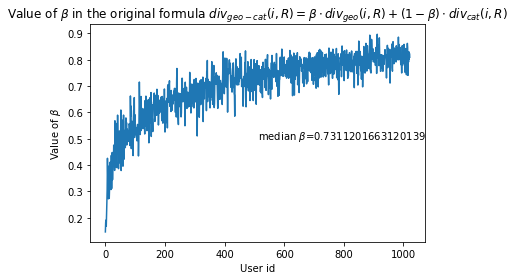

In [15]:
plt.plot(geo_div_prop/(geo_div_prop+cat_div_prop))
plt.xlabel("User id")
plt.ylabel("Value of $\\beta$")
plt.title("Value of $\\beta$ in the original formula $div_{geo-cat}(i,R)=\\beta\cdot div_{geo}(i,R)+(1-\\beta)\cdot div_{cat}(i,R)$")

plt.text(training_matrix.shape[0]/2,0.5,"median $\\beta$="+str(np.median(geo_div_prop/(geo_div_prop+cat_div_prop))))
plt.savefig('beta_madison.png')
plt.show()